<a href="https://colab.research.google.com/github/iongie/demo-day-fin-8/blob/Gigih-Santoso/_Demo_day_Fintech_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demo day Fintech 8

"Data tersebut terkait dengan kampanye pemasaran langsung dari lembaga perbankan Portugis. Kampanye pemasaran didasarkan pada panggilan telepon. Seringkali, lebih dari satu kontak ke klien yang sama diperlukan, untuk mengakses apakah produk (deposito berjangka bank) akan ('ya') atau tidak ('tidak') dilanggan oleh pelanggan atau tidak. Folder data berisi dua kumpulan data: -

     train.csv: 45.211 baris dan 18 kolom diurutkan berdasarkan tanggal (dari Mei 2008 hingga November 2010)
     test.csv: 4521 baris dan 18 kolom dengan 10% contoh (4521), dipilih secara acak dari train.csv"

##Setup

In [ ]:
import pathlib
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import data_table
import tensorflow as tf

##Function

function split data

In [ ]:
def dataframe_split(data, ratio= 0.2, shuffle= 0):
  len_ = int(len(data) - (ratio*len(data)))
  if shuffle == 0 :
    part_  = data.iloc[:int(1 + len_)]
    rest_part_ = data.drop(part_.index)
  elif shuffle == 1:
    part_ = data.sample(frac = 1.0 - ratio)
    rest_part_ = data.drop(part_.index)
  return (part_, rest_part_)

fucntion membuat dataset

In [ ]:
def dataframe_to_dataset(data, batch_size=32):
  df = data.copy()
  labels = df.pop('target')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

function preprocessing numeric

In [ ]:
def numeric_preprocessing(name, dataset, num_bins):
  feature_dataset = dataset.map(lambda x,y: x[name])
  layer = tf.keras.layers.Discretization(num_bins=num_bins, epsilon=0.01)
  layer.adapt(feature_dataset)

  return layer

fucntion preprocessing categories

In [ ]:
def categories_preprocessing(name, dataset, dtype):
  if(dtype == "int64"):
    lookup = tf.keras.layers.IntegerLookup()
  else:
    lookup = tf.keras.layers.StringLookup()
  feature_dataset = dataset.map(lambda x,y: x[name])
  lookup.adapt(feature_dataset)

  return lookup

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [ ]:
data_url = "/content/drive/MyDrive/Kumpulan_dataset/fintech_banking_dataset.zip"
data_dir = zipfile.ZipFile(data_url, 'r')
data_dir.extractall("demoday")
data_dir.close()

In [ ]:
dataset_train=pd.read_csv('demoday/train.csv', delimiter=";")
dataset_test=pd.read_csv('demoday/test.csv', delimiter=";")

##Data Explorer

In [ ]:
print(f"jumlah data untuk train adalah {len(dataset_train)}")
print(f"jumlah data untuk test adalah {len(dataset_test)}")

jumlah data untuk train adalah 45211
jumlah data untuk test adalah 4521


In [ ]:
dataset_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
dataset_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


melihat type pada data set

In [ ]:
dataset_train.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [ ]:
train_index = [i for i in dataset_train.drop(columns=['y']).columns]
dataset_train.groupby(by=train_index)["y"].value_counts().unstack().reset_index().sort_values(by=["no"], ascending=True).head()

y,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,no,yes
2,18,student,single,primary,no,1944,no,no,telephone,10,aug,122,3,-1,0,unknown,1.0,NaN
30043,45,entrepreneur,married,primary,no,1953,yes,no,unknown,15,may,95,3,-1,0,unknown,1.0,NaN
30044,45,entrepreneur,married,primary,no,2418,yes,no,unknown,14,may,120,1,-1,0,unknown,1.0,NaN
30045,45,entrepreneur,married,primary,no,5315,yes,yes,cellular,15,may,262,2,-1,0,unknown,1.0,NaN
30046,45,entrepreneur,married,secondary,no,-479,yes,no,cellular,30,jul,167,2,-1,0,unknown,1.0,NaN


In [ ]:
cek_no_yes_max = dataset_train.groupby(by=["age", "job", "marital", "education", "balance", "housing", "loan", "month" , "duration"])["y"].value_counts().unstack().reset_index()

In [ ]:
cek_no_yes_max.loc[cek_no_yes_max['no'].ge(1.0) &cek_no_yes_max['yes'].ge(1.0)]

y,age,job,marital,education,balance,housing,loan,month,duration,no,yes


##Data Preprocessing

mengubah column y, dengan nilai 0 menunjukan *NO* dan nilai 1 menunjukan *YES*

In [ ]:
dataset_train['target'] = dataset_train.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)

dataset_train.drop(columns=["default", "contact",	"day", "campaign",	"pdays",	"previous", "poutcome", "y"], inplace=True)

In [ ]:
dataset_test['target'] = dataset_test.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)

dataset_test.drop(columns=["default", "contact",	"day", "campaign",	"pdays",	"previous", "poutcome", "y"], inplace=True)

dataset train ini merupakan dataframe pandas, split data train dengan ratio 80:20 . 20 % untuk validasi

In [ ]:
train, val = dataframe_split(dataset_train, ratio = 0.2, shuffle=1)

In [ ]:
print(len(train), 'training examples')
print(len(val), 'validation examples')

36169 training examples
9042 validation examples


membuat dataset

In [ ]:
batch_size = 128

train_ds = dataframe_to_dataset(train, batch_size=batch_size)
val_ds = dataframe_to_dataset(val, batch_size=batch_size)
test_ds = dataframe_to_dataset(dataset_test, batch_size=batch_size)

cek data

In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of marital:', train_features['job'])
print('A batch of targets:', label_batch )

Every feature: ['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'month', 'duration']
A batch of marital: tf.Tensor(
[[b'entrepreneur']
 [b'blue-collar']
 [b'self-employed']
 [b'technician']
 [b'admin.']
 [b'technician']
 [b'management']
 [b'technician']
 [b'blue-collar']
 [b'services']
 [b'services']
 [b'retired']
 [b'management']
 [b'services']
 [b'management']
 [b'self-employed']
 [b'blue-collar']
 [b'management']
 [b'services']
 [b'entrepreneur']
 [b'technician']
 [b'management']
 [b'management']
 [b'technician']
 [b'technician']
 [b'retired']
 [b'services']
 [b'blue-collar']
 [b'technician']
 [b'blue-collar']
 [b'retired']
 [b'technician']
 [b'technician']
 [b'management']
 [b'management']
 [b'management']
 [b'management']
 [b'blue-collar']
 [b'management']
 [b'admin.']
 [b'self-employed']
 [b'blue-collar']
 [b'management']
 [b'retired']
 [b'management']
 [b'admin.']
 [b'unemployed']
 [b'housemaid']
 [b'blue-collar']
 [b'blue-collar']
 [b'admin.']
 [b'admin.']
 

test preprocessing

In [ ]:
test_job_col = train_features['job']
test_job_layer = categories_preprocessing(name='job',
                                        dataset=train_ds,
                                        dtype='string')
test_job_layer(test_job_col).numpy()

array([[ 8],
       [ 1],
       [ 7],
       [ 3],
       [ 4],
       [ 3],
       [ 2],
       [ 3],
       [ 1],
       [ 5],
       [ 5],
       [ 6],
       [ 2],
       [ 5],
       [ 2],
       [ 7],
       [ 1],
       [ 2],
       [ 5],
       [ 8],
       [ 3],
       [ 2],
       [ 2],
       [ 3],
       [ 3],
       [ 6],
       [ 5],
       [ 1],
       [ 3],
       [ 1],
       [ 6],
       [ 3],
       [ 3],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 1],
       [ 2],
       [ 4],
       [ 7],
       [ 1],
       [ 2],
       [ 6],
       [ 2],
       [ 4],
       [ 9],
       [10],
       [ 1],
       [ 1],
       [ 4],
       [ 4],
       [ 1],
       [ 1],
       [ 1],
       [ 2],
       [ 2],
       [10],
       [ 4],
       [ 2],
       [ 3],
       [ 3],
       [ 1],
       [ 1],
       [ 2],
       [ 1],
       [ 2],
       [ 2],
       [ 1],
       [ 9],
       [ 1],
       [ 6],
       [ 1],
       [ 1],
       [ 3],
       [ 8],
       [ 2],

In [ ]:
test_duration_col = train_features['duration']
test_duration_layer = numeric_preprocessing(name='duration',
                                            dataset=train_ds,
                                            num_bins=32)
test_duration_layer(test_duration_col)

<tf.Tensor: shape=(128, 1), dtype=int64, numpy=
array([[15],
       [ 8],
       [ 0],
       [ 3],
       [16],
       [29],
       [ 4],
       [10],
       [ 0],
       [ 1],
       [27],
       [15],
       [13],
       [19],
       [ 6],
       [24],
       [20],
       [ 6],
       [ 9],
       [ 9],
       [ 0],
       [12],
       [ 3],
       [11],
       [ 1],
       [15],
       [11],
       [10],
       [20],
       [24],
       [15],
       [28],
       [ 0],
       [ 1],
       [19],
       [ 7],
       [11],
       [22],
       [20],
       [ 1],
       [ 7],
       [ 1],
       [30],
       [16],
       [10],
       [13],
       [26],
       [ 4],
       [15],
       [16],
       [18],
       [19],
       [ 3],
       [28],
       [ 2],
       [ 7],
       [ 1],
       [22],
       [29],
       [22],
       [17],
       [13],
       [ 9],
       [ 7],
       [18],
       [19],
       [ 1],
       [ 2],
       [30],
       [24],
       [ 1],
       [15],
       [18],
   

membagikan column berdasarkan numeric atau categorical integer atau string

In [ ]:
numeric_keys = ["age", "balance", "duration"]
categorical_integer_keys = ["age"]
categorical_string_keys = ["job", "marital", "education", "housing", "loan", "month"]
all_inputs = []
all_preprocessors = []

In [ ]:
for numeric in numeric_keys:
  input = tf.keras.Input(shape=(1,), name=numeric, dtype="int64")
  num_layer = numeric_preprocessing(name=numeric, dataset=train_ds, num_bins=32)
  num_preprocessor = num_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(num_preprocessor)

In [ ]:
for categorical in categorical_string_keys:
  input = tf.keras.Input(shape=(1,), name=categorical, dtype="string")
  cat_layer = categories_preprocessing(name=categorical, dataset=train_ds, dtype="string")
  cat_preprocessor = cat_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_preprocessor)

In [ ]:
all_inputs, all_preprocessors

([<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'age')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'balance')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'duration')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'job')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'marital')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'education')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'housing')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'loan')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'month')>],
 [<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'discretization_9')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'discretization_10')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'discretization_11')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'string_look

##Model

In [ ]:
all_features = tf.keras.layers.concatenate(all_preprocessors)
x = tf.keras.layers.Embedding(input_dim=128, output_dim=128)(all_features)

x = tf.keras.layers.Conv1D(8, kernel_size=(3), padding="same", activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.MaxPool1D()(x)
x = tf.keras.layers.Conv1D(16,  kernel_size=(3), padding="same" , activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.MaxPool1D()(x)
x = tf.keras.layers.Conv1D(32,  kernel_size=(3), padding="same", activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.MaxPool1D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model = tf.keras.Model(all_inputs, output)

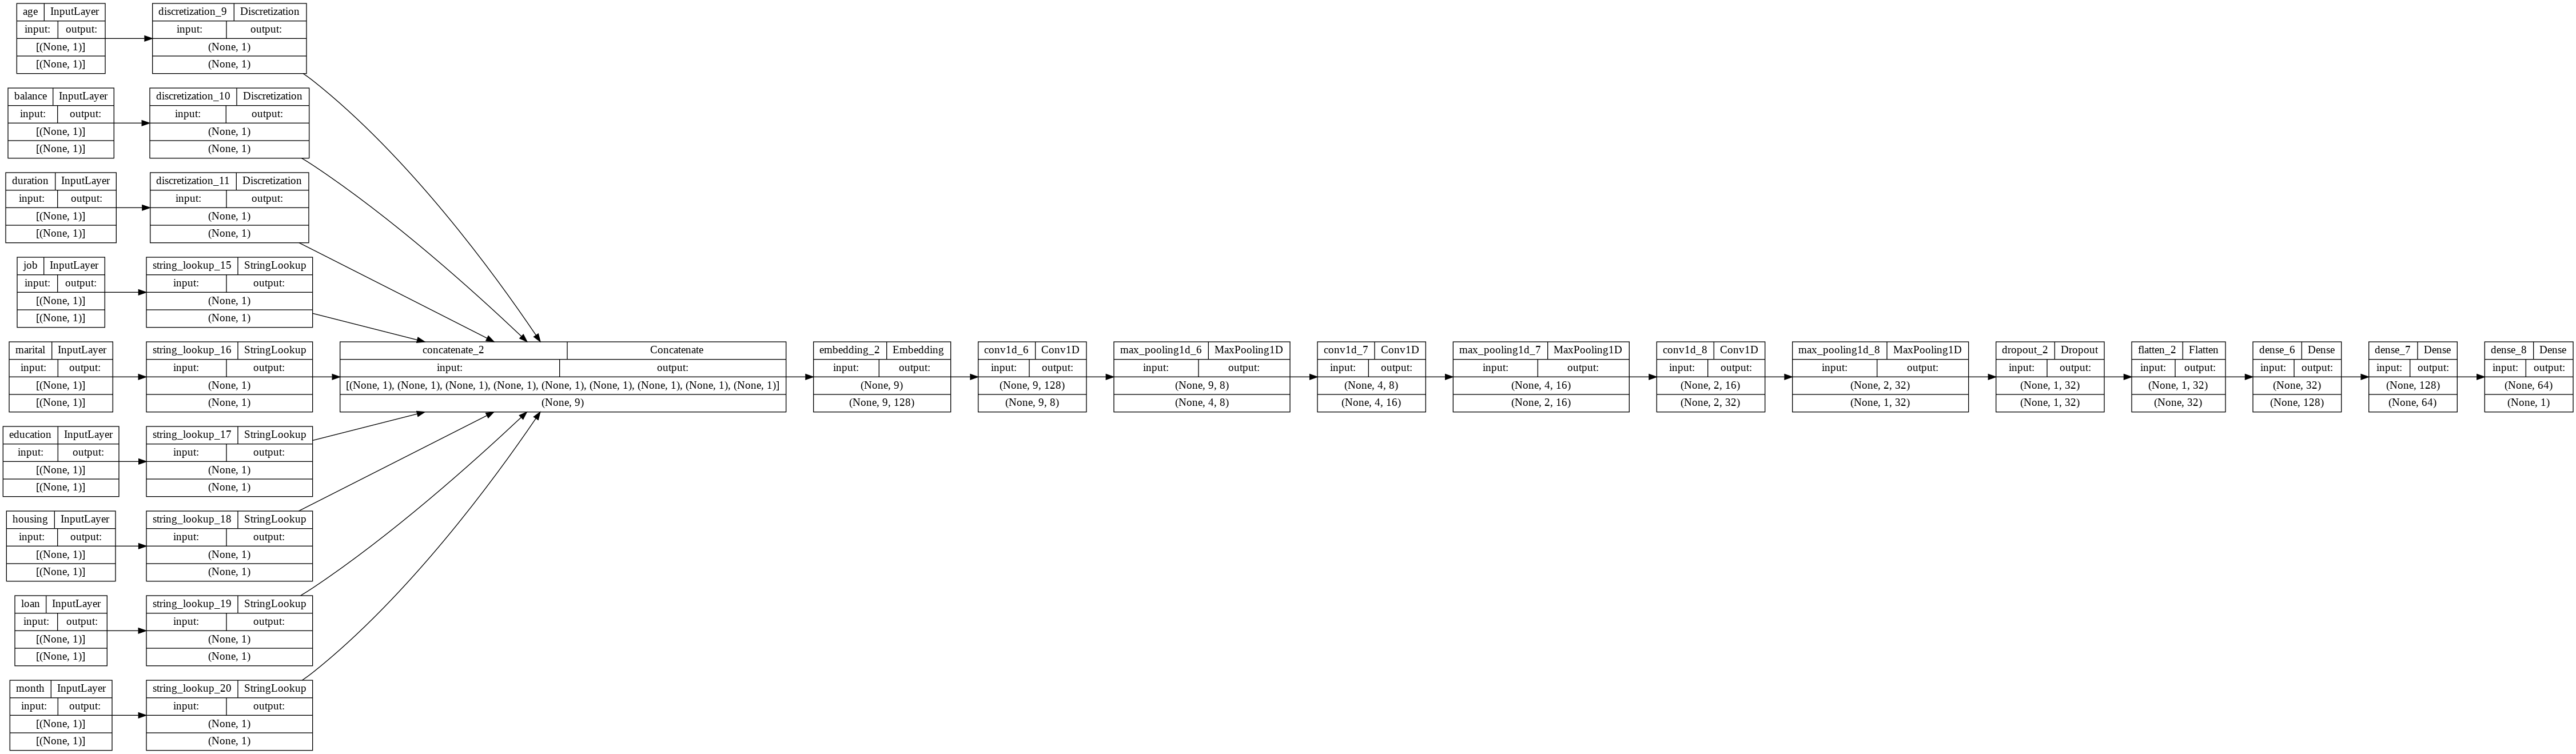

In [ ]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
283/283 [==============================] - 4s 10ms/step - loss: 0.3137 - accuracy: 0.8826 - val_loss: 0.2649 - val_accuracy: 0.8874
Epoch 2/50
283/283 [==============================] - 3s 9ms/step - loss: 0.2567 - accuracy: 0.8871 - val_loss: 0.2541 - val_accuracy: 0.8862
Epoch 3/50
283/283 [==============================] - 3s 9ms/step - loss: 0.2477 - accuracy: 0.8912 - val_loss: 0.2513 - val_accuracy: 0.8853
Epoch 4/50
283/283 [==============================] - 3s 9ms/step - loss: 0.2449 - accuracy: 0.8925 - val_loss: 0.2491 - val_accuracy: 0.8893
Epoch 5/50
283/283 [==============================] - 3s 9ms/step - loss: 0.2421 - accuracy: 0.8937 - val_loss: 0.2462 - val_accuracy: 0.8905
Epoch 6/50
283/283 [==============================] - 3s 9ms/step - loss: 0.2408 - accuracy: 0.8939 - val_loss: 0.2451 - val_accuracy: 0.8918
Epoch 7/50
283/283 [==============================] - 3s 10ms/step - loss: 0.2388 - accuracy: 0.8944 - val_loss: 0.2437 - val_accuracy: 0.8898
Epoc

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
print("Loss", loss)

36/36 [==============================] - 0s 4ms/step - loss: 0.2242 - accuracy: 0.8985
Accuracy 0.8984737992286682
Loss 0.22419528663158417


In [ ]:
dataset_test.sort_values(by=["target"], ascending=False).head()

,age,job,marital,education,balance,housing,loan,month,duration,target
3930,51,retired,divorced,secondary,1679,no,no,aug,417,1
702,32,management,divorced,tertiary,874,no,no,aug,1282,1
1876,26,blue-collar,single,primary,-887,yes,no,may,827,1
2865,51,housemaid,divorced,secondary,9228,no,no,jul,655,1
1872,34,admin.,married,secondary,247,no,no,oct,401,1


In [ ]:
sample = {
    'age': 51,
    'job': 'retired',
    'marital': 'divorced',
    'education': 'secondary',
    'balance': 1679,
    'housing': 'no',
    'loan': 'no',
    'month': 'aug',
    'duration': 417
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "Probabilitas untuk berlangganan deposito berjangka adalah "
    "of getting adopted." % (100 * prob)
)

print(predictions, (100 * prob))

Probabilitas untuk berlangganan deposito berjangka adalah of getting adopted.
[[0.04223123]] tf.Tensor([51.055622], shape=(1,), dtype=float32)
